These are some basic utility functions we will need. 

In [222]:
from __future__ import division
from collections import Counter, defaultdict
import os, math, random, re, glob #Imports a bunch of modules we will need
import pandas, requests, json
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups 
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
%matplotlib inline

Some functions for splitting data

In [226]:
def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def train_test_split(x, y, test_pct):
    data = zip(x, y)                              # pair corresponding values ; zip combines lists to tuples
    train, test = split_data(data, 1 - test_pct)  # split the dataset of pairs
    x_train, y_train = zip(*train)                # magical un-zip trick
    x_test, y_test = zip(*test)
    return x_train, x_test, y_train, y_test

# NAIVE BAYES

## Naive Bayes from Scratch

First, let's build a Naive Bayes classifier from scratch. This example drawn from *Data Science from Scratch* by Joel Grus. 

### Mathematical Preliminaries

Recall the key independence assumption of Naive Bayes: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$

To be concrete, let's assume we are building a spam filter. 

Given a vocabulary $w_1,\dots,w_n$, let $X_i$ be the event "message contains $w_i$." $X_i = x_i, x_i \in \{0,1\}$. 

$S$ is the event "message is spam" and $\neg S$ is the event "message is not spam."

According to Bayes' Theorem 

$P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n)} = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)\, + \,P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)P(\neg S)}$

We further assume that we have no knowledge of the prior probability of spam; so $P(S) = P(\neg S) = 0.5$ (this is the principle of indifference)

With this simplification, $P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)\, +\, P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)}$ 

Now we make the Naive Bayes assumption: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$
    
We can estimate $P(X_i = x_i\,|\,S)$ by computing the fraction of spam messages containing the word $i$, e.g., Obamacare. 

Smoothing: $P(X_i\,|\,S) = \frac{(k + \textrm{number of spams containing}\, w_i)}{(2k + \textrm{number of spams})}$



### Now we are going to code this up

First we will "tokenize" our input, i.e., turn text into presence/absence of words. 

In [227]:
def tokenize(message): #Note: no stemming
    message = message.lower() # convert to lowercase
    all_words = re.findall("[a-z0-9']+", message) # use re to extract the words
    return set(all_words) # remove duplicates because we are creating a set

Now we need to count the number of times each word shows up in spam and non-spam

In [228]:
def count_words(training_set):
    """training set consists of pairs (message, is_spam)""" 
    counts = defaultdict(lambda: [0, 0]) #This is a tricky bit of Python magic, makes a dictionary initialized to [0,0]
    for message, is_spam in training_set: #Here I step through the training set.
        for word in tokenize(message): 
            counts[word][0 if is_spam else 1] += 1
    return counts

We need a function to convert these counts into (smoothed) probabilities

In [229]:
def word_probabilities(counts, total_spams, total_non_spams, k=0.5): #What is the smoothing parameter?
    """turn the word_counts into a list of triplets 
    w, p(w | spam) and p(w | ~spam)"""
    return [(w,
             (spam + k) / (total_spams + 2 * k),
             (non_spam + k) / (total_non_spams + 2 * k)) #This uses list comprehension. 
             for w, (spam, non_spam) in counts.items()]  #Replace .iteritems with .items for Python3

Now we need to come up with a way to compute the spam probability for a message, given word probabilities. With the Naive Bayes assumption, we *would* be multiplying together a bunch of probabilities. This is bad (underflow) so we compute:

$p_1 *\dots*p_n = \exp(\, \log(p_1) + \dots + \log(p_n)\,)$; recall $\log(ab) = \log a + \log b$ and $\exp(\, \log x \,) = x$

Thank you, John Napier (1550-1617)

In [230]:
def spam_probability(word_probs, message):
    message_words = tokenize(message)
    log_prob_if_spam = log_prob_if_not_spam = 0.0 #Initialize; we are working with log probs to deal with underflow.

    for word, prob_if_spam, prob_if_not_spam in word_probs: #We iterate over all possible words we've observed

        # for each word in the message, 
        # add the log probability of seeing it 
        if word in message_words:
            log_prob_if_spam += math.log(prob_if_spam) #This is prob of seeing word if spam
            log_prob_if_not_spam += math.log(prob_if_not_spam) #This is prob of seeing word if not spam

        # for each word that's not in the message
        # add the log probability of _not_ seeing it
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
    P = 1/(1 + math.exp(log_prob_if_not_spam - log_prob_if_spam))
    #prob_if_spam = math.exp(log_prob_if_spam) #Compute numerator
    #prob_if_not_spam = math.exp(log_prob_if_not_spam)
    #return prob_if_spam / (prob_if_spam + prob_if_not_spam) #Compute whole thing and return
    return P

Think: how would this change if $P(S) \neq P(\neg S)$

Now we write a class (this is a Python term) for our Naive Bayes Classifier

In [231]:
class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = len([is_spam 
                         for message, is_spam in training_set 
                         if is_spam]) #This is also list comprehension
        num_non_spams = len(training_set) - num_spams

        # run training data through our "pipeline"
        word_counts = count_words(training_set)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message


We'll need a special utility function for reading in the data

In [232]:
def get_subject_data(path):
    data = []
    # regex for stripping out the leading "Subject:" and any spaces after it
    subject_regex = re.compile(r"^Subject:\s+")
    # glob.glob returns every filename that matches the wildcarded path
    for fn in glob.glob(path):
        is_spam = "ham" not in fn
        
        #with open(fn,'r') as file: #PYTHON 3 USERS: COMMENT THIS OUT AND USE LINE BELOW
        with open(fn,'r',errors='surrogateescape') as file: 
            for line in file:
                if line.startswith("Subject:"):
                    subject = subject_regex.sub("", line).strip()
                    data.append((subject, is_spam))

    return data

Grab data from: https://spamassassin.apache.org/publiccorpus/

Get the ones with 20021010 prefixes and put them into the data folder under the current working directory.

In [233]:
path = os.getcwd() + '/data/*/*/*'

In [234]:
data = get_subject_data(path)

In [235]:
len(data) #How many 

3423

In [236]:
data[1000] #Let's look

('Re: The 3rd Annual Consult Hyperion Digital Identity Forum', False)

To train the model, we'll need to split our data into training & test

In [237]:
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75) #Recall what the second argument does here

In [238]:
classifier = NaiveBayesClassifier() #Create an instance of our classifier

In [239]:
classifier.train(train_data) #Train the classifier on the training data

In [240]:
len(train_data)

2547

Some simple evaluation:

In [241]:
# triplets (subject, actual is_spam, predicted spam probability)
classified = [(subject, is_spam, classifier.classify(subject))
              for subject, is_spam in test_data]

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = Counter((is_spam, spam_probability > 0.5) # (actual, predicted)
                     for _, is_spam, spam_probability in classified)

In [242]:
counts #Let's see how we did!

Counter({(False, False): 704,
         (False, True): 33,
         (True, False): 38,
         (True, True): 101})

Precision:

In [243]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.753731343283582


Recall:

In [244]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

0.7266187050359713


F-measure:

In [245]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.73992673992674


Let's look at how the emails are classified.

In [246]:
df_classification = pandas.DataFrame(classified, columns = ['email', 'spam', 'posterior'])
df_classification = df_classification.round(3)

In [247]:
df_classification[:10]

,email,spam,posterior
0,Re: New Sequences Window,False,0.000
1,[zzzzteana] RE: Alexander,False,0.000
2,Re: [zzzzteana] Nothing like mama used to make,False,0.001
3,Re: New Sequences Window,False,0.000
4,Re: New Sequences Window,False,0.000
5,[ILUG] Re: Problems with RAID1 on cobalt raq3,False,0.001
6,Re: New Sequences Window,False,0.000
7,The case for spam,False,0.002
8,[IIU] Eircom aDSL Nat'ing,False,0.069
9,[zzzzteana] Which Muppet Are You?,False,0.036


The ROC curve:

In [248]:
x, y, _ = sklearn.metrics.roc_curve(df_classification['spam'], df_classification['posterior'])
roc_auc = sklearn.metrics.auc(x,y)

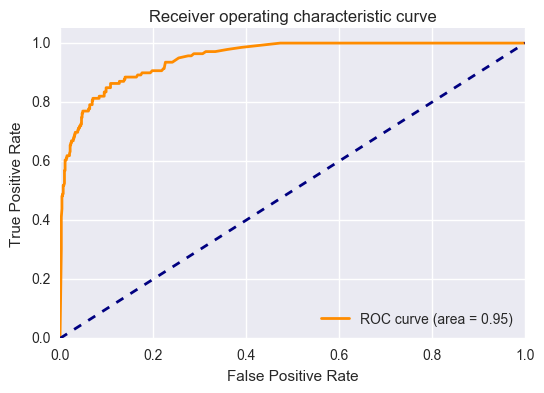

In [249]:
plt.figure()
plt.plot(x,y, color = 'darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

**Think**: what will happen if I change my spam threshold from 0.5?

**Think**: what decision rule are we using, when we assign the class label $\hat{y} = S$ when $P(S\,|\,X_1\dots X_n) = \frac{P(S)\prod_i P(X_i = x_i|S)}{P(\textbf{X})} > 0.5$

**Think**: what will happen if I split the data differently (e.g., less training data, more testing data). Try it!

We can also find words that lead to a high probability of spam (using Bayes' Theorem):

In [250]:
def p_spam_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_spam, prob_if_not_spam = word_prob
    return prob_if_spam / (prob_if_spam + prob_if_not_spam)

In [251]:
words = sorted(classifier.word_probs,key=p_spam_given_word)

In [252]:
spammiest_words = words[-15:]
hammiest_words = words[:15]

In [253]:
spammiest_words

[('needed', 0.01780821917808219, 0.00022893772893772894),
 ('norton', 0.02054794520547945, 0.00022893772893772894),
 ('29', 0.02054794520547945, 0.00022893772893772894),
 ('95', 0.02054794520547945, 0.00022893772893772894),
 ('per', 0.02054794520547945, 0.00022893772893772894),
 ('guaranteed', 0.023287671232876714, 0.00022893772893772894),
 ('mortgage', 0.023287671232876714, 0.00022893772893772894),
 ('adv', 0.026027397260273973, 0.00022893772893772894),
 ('zzzz', 0.026027397260273973, 0.00022893772893772894),
 ('clearance', 0.026027397260273973, 0.00022893772893772894),
 ('year', 0.028767123287671233, 0.00022893772893772894),
 ('sale', 0.031506849315068496, 0.00022893772893772894),
 ('rates', 0.031506849315068496, 0.00022893772893772894),
 ('systemworks', 0.036986301369863014, 0.00022893772893772894),
 ('money', 0.03972602739726028, 0.00022893772893772894)]

In [254]:
hammiest_words

[('spambayes', 0.0013698630136986301, 0.04601648351648352),
 ('users', 0.0013698630136986301, 0.036401098901098904),
 ('razor', 0.0013698630136986301, 0.030906593406593408),
 ('zzzzteana', 0.0013698630136986301, 0.029075091575091576),
 ('sadev', 0.0013698630136986301, 0.026785714285714284),
 ('ouch', 0.0013698630136986301, 0.02358058608058608),
 ('bliss', 0.0013698630136986301, 0.021749084249084248),
 ('wedded', 0.0013698630136986301, 0.021291208791208792),
 ('selling', 0.0013698630136986301, 0.021291208791208792),
 ('apt', 0.0013698630136986301, 0.021291208791208792),
 ('perl', 0.0013698630136986301, 0.0190018315018315),
 ('spamassassin', 0.0013698630136986301, 0.018543956043956044),
 ('satalk', 0.00410958904109589, 0.053800366300366304),
 ('problem', 0.0013698630136986301, 0.017170329670329672),
 ('alsa', 0.0013698630136986301, 0.016712454212454212)]

# Let' Try it on Our Clinton Obama Corpora

In [255]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)

    #Check for rate limiting
    if r.status_code != 200:
        raise RuntimeError("Github didn't like your request, you have probably been rate limited.")
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

'''
#Uncomment this to download your own data

targetSenator = 'Obama'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

ObamaReleases = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
ObamaReleases = ObamaReleases.append(targetDF, ignore_index = True)

targetSenator = 'Clinton'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

ClintonReleases = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
ClintonReleases = ClintonReleases.append(targetDF, ignore_index = True)

ObamaClintonReleases = ObamaReleases.append(ClintonReleases, ignore_index = True)
ObamaClintonReleases.to_csv("data/ObamaClintonReleases.csv")

'''



#senReleasesTraining = pandas.read_csv("data/senReleasesTraining.csv")


'\n#Uncomment this to download your own data\n\ntargetSenator = \'Obama\'# = [\'Voinovich\', \'Obama\', \'Whitehouse\', \'Snowe\', \'Rockefeller\', \'Murkowski\', \'McCain\', \'Kyl\', \'Baucus\', \'Frist\']\n\nObamaReleases = pandas.DataFrame()\n\nprint("Fetching {}\'s data".format(targetSenator))\ntargetDF = getGithubFiles(\'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}\'.format(targetSenator), maxFiles = 2000)\ntargetDF[\'targetSenator\'] = targetSenator\nObamaReleases = ObamaReleases.append(targetDF, ignore_index = True)\n\ntargetSenator = \'Clinton\'# = [\'Voinovich\', \'Obama\', \'Whitehouse\', \'Snowe\', \'Rockefeller\', \'Murkowski\', \'McCain\', \'Kyl\', \'Baucus\', \'Frist\']\n\nClintonReleases = pandas.DataFrame()\n\nprint("Fetching {}\'s data".format(targetSenator))\ntargetDF = getGithubFiles(\'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}\'.format(targetSenator), maxFiles = 2000)\ntargetDF[\'targetSenator\'

In [417]:
ObamaClintonReleases = pandas.read_csv("data/ObamaClintonReleases.csv")
ObamaClintonReleases = ObamaClintonReleases.dropna(axis=0, how='any')

Let's turn the 'targetSenator' column into a binary variable.

In [418]:
def IsObama(targetSenator):
    if targetSenator == 'Obama':
        isObama = True
    elif targetSenator == 'Clinton':
        isObama = False
    return(isObama)

In [419]:
ObamaClintonReleases['IsObama'] = ObamaClintonReleases['targetSenator'].apply(lambda x: IsObama(x))

Let's split the data into training data and test data.

In [420]:
data = list(zip(ObamaClintonReleases['text'], ObamaClintonReleases['IsObama']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [421]:
print (len(train_data))
print (len(test_data))

1275
434


First, let's try with a logistic regression.
Turn the training dataset into a tf-idf matrix

In [422]:
train_data_df = pandas.DataFrame(train_data, columns = ['email', 'true label'])

In [443]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['email'])

In [446]:
TFVects.shape

(1275, 10876)

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. Let's do a PCA. You have already seen it in week 3. Here we are less less concerned about visualization, so all principal components are calculated.

In [432]:
PCA = sklearn.decomposition.PCA
pca = PCA().fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

Visualization:

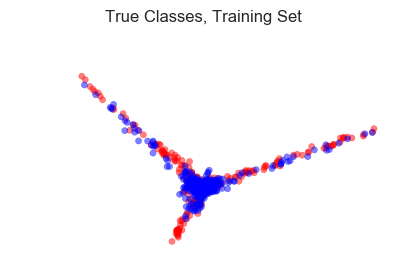

In [433]:
colordict = {
True: 'red',
False: 'blue',
    }
colors = [colordict[c] for c in train_data_df['true label']]
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Clinton from Obama well. Let's do a screeplot and see how many dimensions we need.

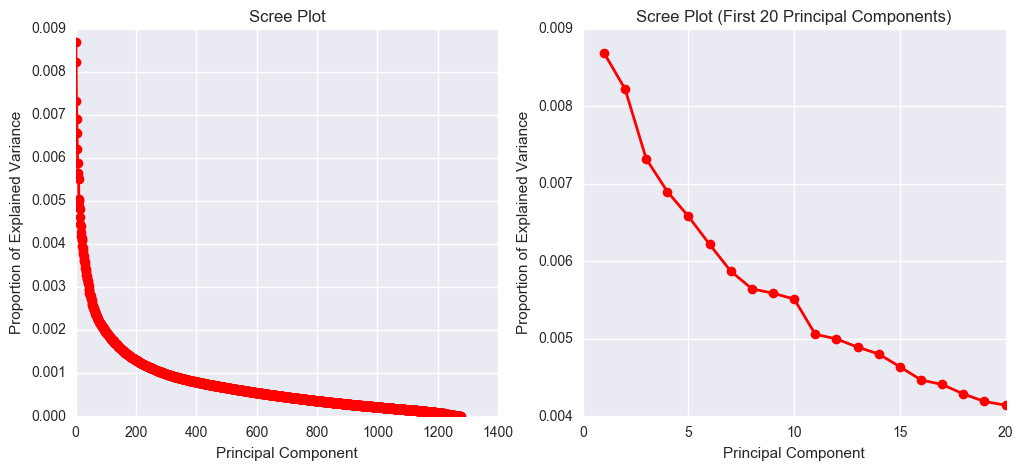

In [434]:
n = TFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [435]:
X = reduced_data[:, :10]

In [436]:
Y = np.array([int(label) for label in train_data_df['true label']])

Fit a logistic regression.

In [437]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on our training dataset. The mean accuracy is only about 66%.

In [438]:
logistic.score(X,Y)

0.66039215686274511

How does it perform on the testing dataset?

In [439]:
test_data_df = pandas.DataFrame(test_data, columns = ['email', 'true label'])
TFVects_test = TFVectorizer.transform(test_data_df['email'])
reduced_data_test = pca.transform(TFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in test_data_df['true label']])
logistic.score(X_test, Y_test)

0.65207373271889402

Slightly Poorer. How about using more dimensions?

In [272]:
X = reduced_data[:, :40]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :40]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.741960784314
0.741935483871


In [273]:
X = reduced_data[:, :100]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :100]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.84862745098
0.794930875576


In [274]:
X = reduced_data[:, :200]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :200]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.886274509804
0.815668202765


In [275]:
X = reduced_data[:, :400]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :400]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.925490196078
0.820276497696


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 80%.

Or, we can use the original tf-idf matrix as our covariates and enforce an 'L1' penalty.

In [453]:
X = TFVects
logistic_l1= linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(X, Y)
print(logistic_l1.score(X,Y))

0.840784313725


Train the model using training data, and then test it on the testing data.

In [455]:
print(logistic_l1.score(TFVects_test,Y_test))

0.806451612903


80% accuracy seems like the best we can get by using a logistic regression. Let's try with Naive Bayes.

In [456]:
classifier = NaiveBayesClassifier() 
classifier.train(train_data)

Let's evaluate the result on the test data.

In [457]:
classified = [(subject, is_spam, classifier.classify(subject))
              for subject, is_spam in test_data]

counts = Counter((is_spam, spam_probability > 0.5) 
                     for _, is_spam, spam_probability in classified)

counts

Counter({(False, False): 257, (False, True): 1, (True, True): 176})

Precision:

In [458]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.9943502824858758


Recall:

In [459]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

1.0


F-measure:

In [460]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.9971671388101983


In [461]:
df_classification = pandas.DataFrame(classified, columns = ['press release', 'is Obama', 'posterior probability'])
df_classification = df_classification.round(3)

In [462]:
df_classification

,press release,is Obama,posterior probability
0,Obama Calls on IRS to Protect Taxpayers ...,True,1.000
1,Statement from Senator Barack Obama on the ...,True,1.000
2,Legislation to Increase Availability and Us...,True,1.000
3,Statement of Senator Barack Obama on Senate...,True,1.000
4,Obama Cosponsors One Year Moratorium on All...,True,1.000
5,Obama Statement on the Withdrawal of the No...,True,1.000
6,Obama Again Calls for Independent Ethics Co...,True,1.000
7,Obama Rice Must Provide Answers About New ...,True,1.000
8,Senators Introduce Bill to Provide Housing ...,True,1.000
9,Obama Statement on the Attempted Assassinat...,True,1.000


Let's take a look at how well our posterior distribution is.

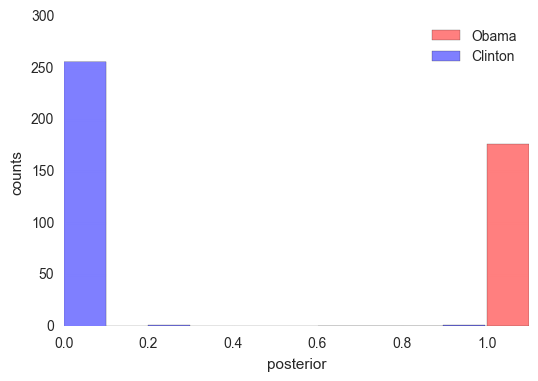

In [463]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(False)
ax1.set_frame_on(False)
df_classification[df_classification['is Obama'] == True]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Obama', color = 'red')
df_classification[df_classification['is Obama'] == False]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Clinton', color = 'blue')
ax1.set_xlim((0,1.1))
ax1.legend()
ax1.set_xlabel('posterior')
ax1.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate.

In [464]:
def p_obama_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_obama, prob_if_not_obama = word_prob
    return prob_if_obama / (prob_if_obama + prob_if_not_obama)

In [465]:
words = sorted(classifier.word_probs,key=p_obama_given_word)

In [466]:
Obama_words = words[-15:]
Clinton_words = words[:15]

In [467]:
Obama_words

[('christina', 0.07397003745318352, 0.0006729475100942127),
 ('40b', 0.07958801498127341, 0.0006729475100942127),
 ('sdb', 0.07958801498127341, 0.0006729475100942127),
 ('gibbs', 0.3061797752808989, 0.002018842530282638),
 ('202', 0.6320224719101124, 0.0033647375504710633),
 ('brundage', 0.1451310861423221, 0.0006729475100942127),
 ('labolt', 0.17322097378277154, 0.0006729475100942127),
 ('5566', 0.1900749063670412, 0.0006729475100942127),
 ('228', 0.6207865168539326, 0.002018842530282638),
 ('julian', 0.22940074906367042, 0.0006729475100942127),
 ('ortiz', 0.2649812734082397, 0.0006729475100942127),
 ('newsletters', 0.3192883895131086, 0.0006729475100942127),
 ('tommy', 0.3398876404494382, 0.0006729475100942127),
 ('vietor', 0.3398876404494382, 0.0006729475100942127),
 ('5511', 0.42790262172284643, 0.0006729475100942127)]

In [289]:
Clinton_words

[('yorkers', 0.0009363295880149813, 0.13526244952893673),
 ('buffalo', 0.0009363295880149813, 0.07200538358008075),
 ('rodham', 0.012172284644194757, 0.933378196500673),
 ('welcomes', 0.0009363295880149813, 0.06662180349932706),
 ('click', 0.0009363295880149813, 0.0639300134589502),
 ('clintons', 0.0009363295880149813, 0.06123822341857335),
 ('albany', 0.0009363295880149813, 0.05450874831763122),
 ('manhattan', 0.0009363295880149813, 0.0531628532974428),
 ('hudson', 0.0009363295880149813, 0.0477792732166891),
 ('tourists', 0.0009363295880149813, 0.046433378196500674),
 ('niagara', 0.0009363295880149813, 0.04508748317631225),
 ('upstate', 0.0009363295880149813, 0.04508748317631225),
 ('yorks', 0.0009363295880149813, 0.04374158815612382),
 ('westchester', 0.0009363295880149813, 0.039703903095558546),
 ('faa', 0.0009363295880149813, 0.03835800807537012)]

## Multinomial Naive Bayes

Well suited to text applications, this generating model assumes that the features are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). Features might be, e.g., the count of various words in a text. 

Let's use again the dataset we used in week 3.

In [468]:
data = fetch_20newsgroups() #Free data to play with: documents from a newsgroup corpus.
data.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

This dataset has a built in breakdown into training and testing sets. We can pick specific categories, and pull the relevant training and testing sets. 

In [469]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [292]:
train['target']

array([2, 2, 1, ..., 2, 3, 1], dtype=int64)

In [293]:
len(train.data) #See how many training examples

2153

In [294]:
len(test.data) #Ditto for testing -- it's about 60% training, 40% testing

1432

In [295]:
print(train.data[5]) #Look at an example
#print(train.target_names[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document but rarely across documents in the corpus (more distinctive). 

We also take advantage of a cool feature of Scikit-Learn: we can make pipelines...

In [296]:
model = make_pipeline(TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2'), MultinomialNB()) #This applies the vectorizer, then trains Multinomial NB

In [297]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [298]:
labels = model.predict(test.data)

In [299]:
labels.size

1432

We can even use a confusion matrix!

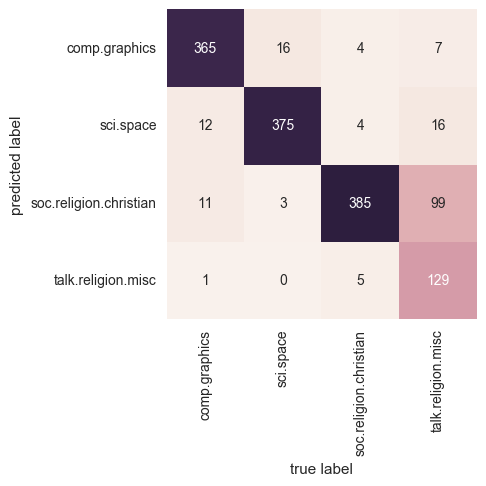

In [300]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [301]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.888801643276
0.875698324022
0.867534845252


Get the ROC curves.
First, we need to binarize the labels.

In [302]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform([1, 3]))

[0 1 2 3]
[[0 1 0 0]
 [0 0 0 1]]


In [303]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [304]:
n_classes = 4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

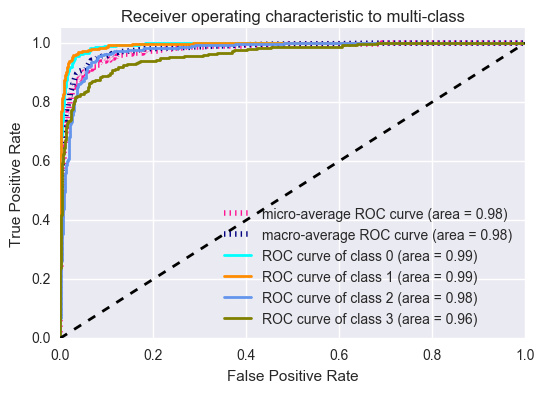

In [305]:
n_classes = 4
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method to see if it can assign it to a category. This might be the main point of a social science application.

In [306]:
def predict_category(s, train=train, model=model): #We just define a simple function here
    return train.target_names[model.predict([s])]

In [307]:
predict_category('rockets')

C:\Users\Shilin\Anaconda2\envs\py3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


'sci.space'

Try it yourself with your own strings!


**Playtime**: Try altering the categories! See if you can come up with ones that are more/less likely to be confused. As an extension, you can use different feature extractors, e.g., CountVectorizer. This just turns each document into a vector of word counts. 

## Now an a more relevant content analysis example

Now, let's add Bernie Sanders to our Obama Clinton dataset.

In [308]:
'''
#Unmark this section if you want to fetch press releases of a nother senator.
targetSenator = 'Sanders'

SandersReleases = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
SandersReleases =SandersReleases.append(targetDF, ignore_index = True)

ObamaClintonSandersReleases = ObamaClintonReleases.append(SandersReleases, ignore_index = True)
ObamaClintonSandersReleases.to_csv("data/ObamaClintonSandersReleases.csv")
'''

'\n#Unmark this section if you want to fetch press releases of a nother senator.\ntargetSenator = \'Sanders\'\n\nSandersReleases = pandas.DataFrame()\n\nprint("Fetching {}\'s data".format(targetSenator))\ntargetDF = getGithubFiles(\'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}\'.format(targetSenator), maxFiles = 2000)\ntargetDF[\'targetSenator\'] = targetSenator\nSandersReleases =SandersReleases.append(targetDF, ignore_index = True)\n\nObamaClintonSandersReleases = ObamaClintonReleases.append(SandersReleases, ignore_index = True)\nObamaClintonSandersReleases.to_csv("data/ObamaClintonSandersReleases.csv")\n'

In [527]:
ObamaClintonSandersReleases = pandas.read_csv("data/ObamaClintonSandersReleases.csv")
ObamaClintonSandersReleases = ObamaClintonSandersReleases.dropna(axis=0, how='any')

Let's split the data into training data and test data.

In [528]:
data = list(zip(ObamaClintonSandersReleases['text'], ObamaClintonSandersReleases['targetSenator']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [529]:
print (len(train_data))
print (len(test_data))

1476
507


In [530]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [531]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [314]:
labels = model.predict(test.data)

In [315]:
labels.size

507

In [316]:
model.classes_

array(['Clinton', 'Obama', 'Sanders'], 
      dtype='<U7')

Confusion matrix:

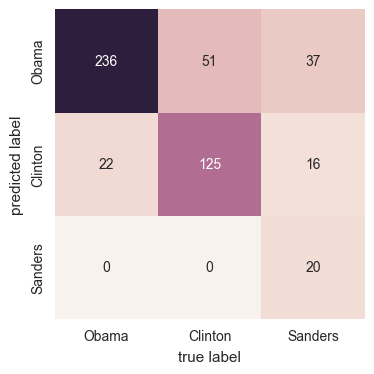

In [317]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [318]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.780858483391
0.751479289941
0.730628152246


Get the ROC curves.
First, we need to binarize the labels.

In [319]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform(['Clinton', 'Obama']))

['Clinton' 'Obama' 'Sanders']
[[1 0 0]
 [0 1 0]]


In [320]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [321]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

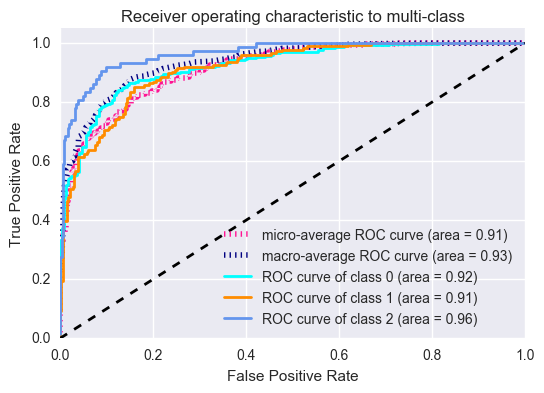

In [322]:
n_classes = 3
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and using the predict method see if it can assign it to a category. This might be the main point of a social science application.

In [323]:
model.predict(['money'])

array(['Clinton'], 
      dtype='<U7')

In [324]:
model.predict(['Wall Street'])

array(['Clinton'], 
      dtype='<U7')

In [325]:
model.predict(['Chicago'])

array(['Obama'], 
      dtype='<U7')

# DECISION TREES

We are going to stick to Scikit-Learn here.

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

Let's create something to learn:

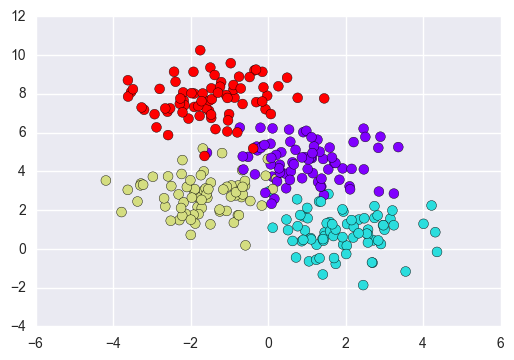

In [326]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Now we import our Decision Tree classifier from sklearn.tree (very familiar syntax!) and fit it using the fit method.

In [327]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X,y)

To see what's going on visually with the classification, we can use this (complex) visualizer. 

In [328]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [329]:
Xnew, ynew = make_blobs(n_samples=1000, centers=4,
                random_state=0, cluster_std=1.0)

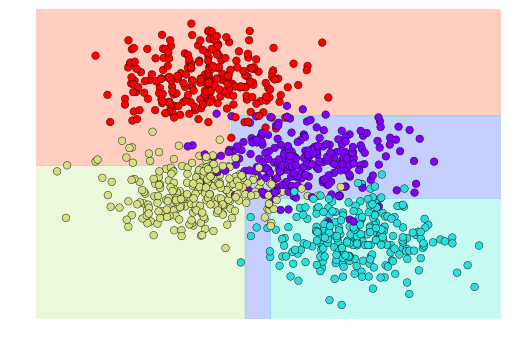

In [330]:
visualize_classifier(DecisionTreeClassifier(max_depth=4,random_state=0), Xnew, ynew, X, y) #We train on the full data

In [331]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_score(ynew,DecisionTreeClassifier(max_depth=10,random_state=0).fit(X,y).predict(Xnew))

0.91400000000000003

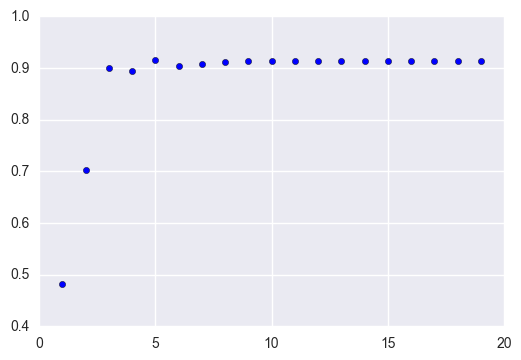

In [332]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X,y)
    score = accuracy_score(ynew,tree2.predict(Xnew))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)

Near the cluster boundaries, the shape is pretty weird. Overfitting!

In [333]:
from sklearn.cross_validation import train_test_split #Can use this to split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5,random_state=1) #test_size means a 50/50 split
print(len(X))
print(len(Xtrain))
print(len(Xtest))

300
150
150


With some abuse of notation, we can use the visualizer to plot first a classifier trained on the "training" half of the data.

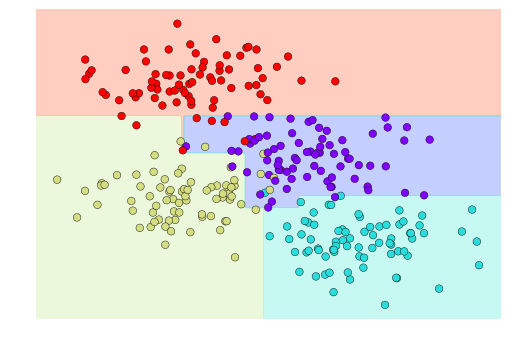

In [334]:
visualize_classifier(DecisionTreeClassifier(max_depth=5,random_state=0), X, y, Xtrain, ytrain) #Train with half the data

Now we can train on the second half of the data--allegedly the test data--to see how different training sets affect the decision boundaries.

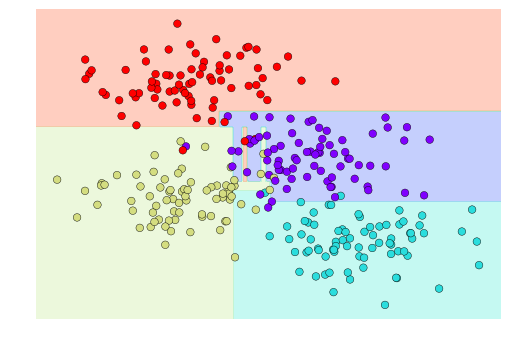

In [335]:
visualize_classifier(DecisionTreeClassifier(random_state=0), X, y, Xtest, ytest) #Train with other half of the data

Finally, we can get a sense of the performance by training on the training data, but PLOTTING the test data

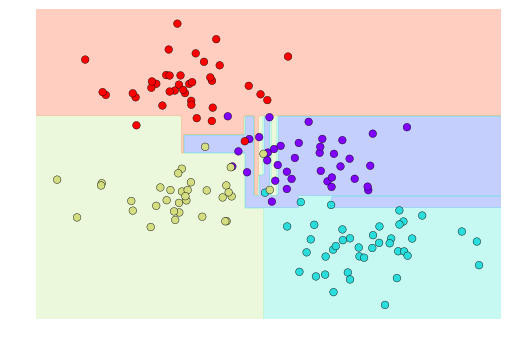

In [336]:
visualize_classifier(DecisionTreeClassifier(), Xtest, ytest, Xtrain, ytrain) #Trains with train data, plots test data

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [337]:
from sklearn.tree import DecisionTreeClassifier  #Just in case
from sklearn.ensemble import BaggingClassifier #The bagging

tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [338]:
?BaggingClassifier #Learn more

In [339]:
bag.fit(X,y) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [342]:
Xnew, ynew = make_blobs(n_samples=10000, centers=4,
                random_state=0, cluster_std=1.0)

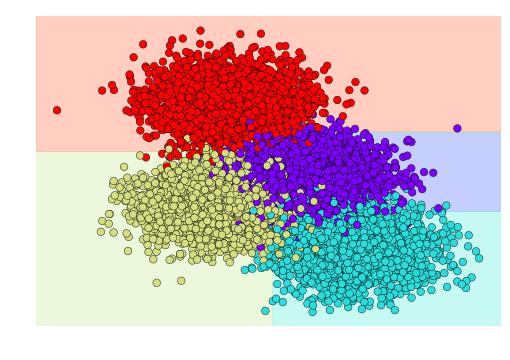

In [343]:
visualize_classifier(bag,Xnew,ynew,X,y) #And visualize
#Remember we can give the full data as training data, as bag automatically splits and trains

In [344]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
recall_score(ynew,bag.predict(Xnew),average='weighted')

0.9204

# Let's try it on the Clinton Obama Sanders dataset.

In [356]:
TFVects = TFVectorizer.fit_transform(train.data)

In [351]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(TFVects,train.target)

In [357]:
TFVects_test = TFVectorizer.transform(test.data)

In [358]:
labels = tree.predict(TFVects_test)

Confusion matrix:

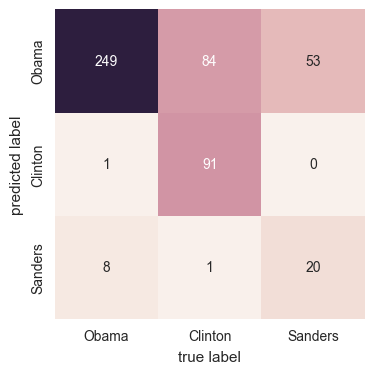

In [361]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [362]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.770930642843
0.710059171598
0.685718256036


Not really better than Multinomial Naive Bayes. Let's try a random forest.

In [363]:
bag.fit(TFVects,train.target) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [364]:
labels = bag.predict(TFVects_test)

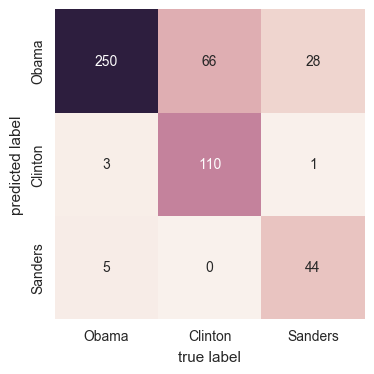

In [365]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [366]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.834074125861
0.79684418146
0.789859355759


The performance is better!

## Brief aside: Random forest regression (Optional)

First, let's create a challenging dataset.

In [188]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200) #200 uniformly distributed random numbers between 0 and 10
def model(x, sigma=0.3): 
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x)) #Create 200 random numbers, normally distributed

    return slow_oscillation + fast_oscillation + noise

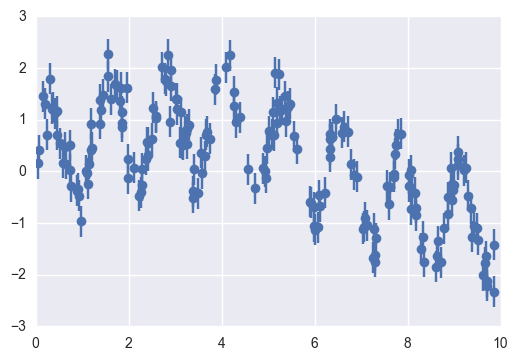

In [189]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); #Shows one std around point
#plt.scatter(x, y); #Plots the actual points

First we will try to learn this with something simple; a single decision tree, but one that is a regressor, not a classifier.

In [190]:
#First try to learn this with something simple --  a single decision tree regressor
from sklearn.tree import DecisionTreeRegressor

# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(x[:,None], y)
regr_2.fit(x[:,None], y)
regr_3.fit(x[:,None], y)

# Predict
xfit = np.linspace(0, 10, 1000)
yfit_1 = regr_1.predict(xfit[:, None]) #xfit[:,None] is a work-around to pass a 1d feature matrix
yfit_2 = regr_2.predict(xfit[:, None])
yfit_3 = regr_3.predict(xfit[:, None])

Let's see how these two decision trees do... What do you think will happen as we add depth?

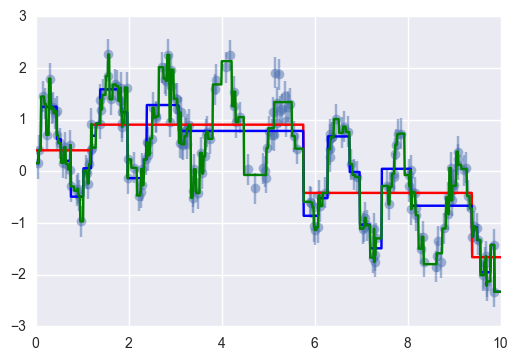

In [191]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit_1, '-r'); #depth = 2
plt.plot(xfit,yfit_2,'-b'); #depth = 5
plt.plot(xfit,yfit_3,'-g'); #depth = 10

Or we can use a **random forest regressor**

In [192]:
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)
    
yfit = forest.predict(xfit[:, None]) #Predictions of the forest model
ytrue = model(xfit, sigma=0) #This is the underlying data, no noise

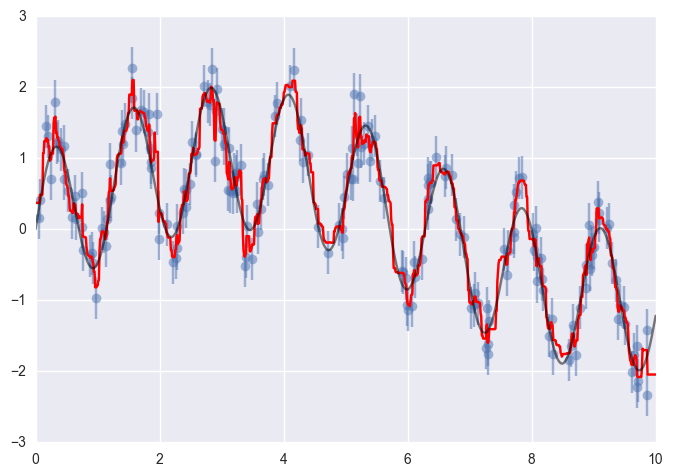

In [86]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

A beautiful fit of the underlying pattern... a lot of the noise has been washed out. This is the power of bagging.

# K-Nearest Neighbors

Let's use newsgroup data again.

In [482]:
categories = ['soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Let's visualize it using PCA.

In [483]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train.data)

In [484]:
TFVects.shape

(1776, 11107)

In [491]:
pca = PCA(n_components= 2)
reduced_data = pca.fit_transform(TFVects.toarray())

In [486]:
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian']

Visualization:

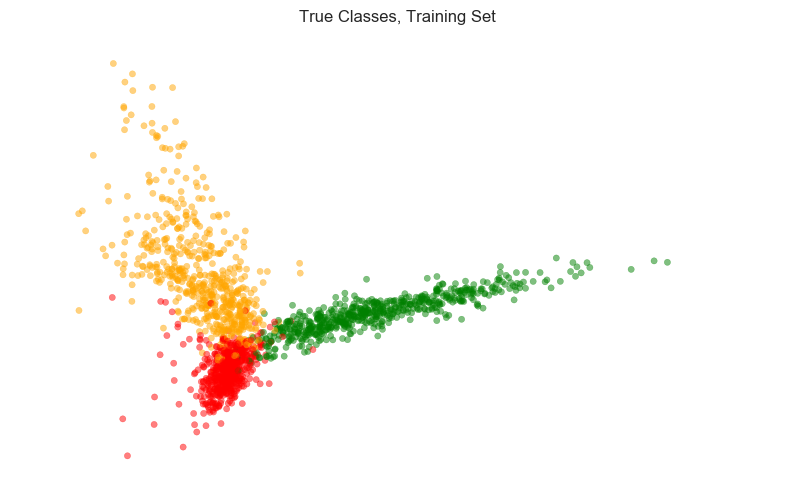

In [487]:
colordict = {
0: 'red',
1: 'orange',
2: 'green',
    }
colors = [colordict[c] for c in train.target]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

Let's initialize our k-nearest neighbors classifier.

In [498]:
n_neighbors = 15
weights="uniform"
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

For visualization purpopose, let's first try applying the k-nearest neighbors classifier to the projected data.

In [500]:
clf.fit(reduced_data, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [501]:
TFVects_test = TFVectorizer.transform(test.data)
reduced_data_test = pca.transform(TFVects_test.toarray())

In [502]:
labels = clf.predict(reduced_data_test)

Confusion matrix:

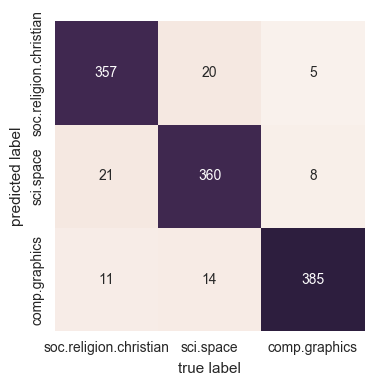

In [503]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [504]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.933023574506
0.933107535986
0.932957048204


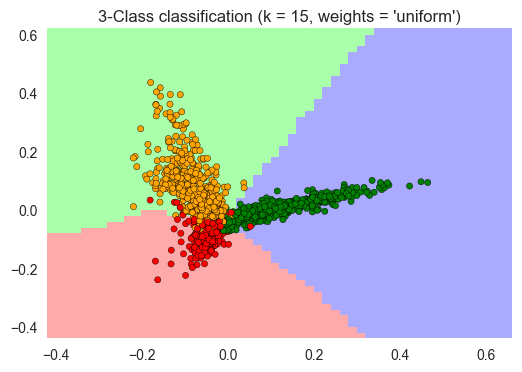

In [508]:
h = .02  # step size in the mesh
# Create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = reduced_data[:, 0].min() - 0.2, reduced_data[:, 0].max() + 0.2
y_min, y_max = reduced_data[:, 1].min() - 0.2, reduced_data[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

Let's use the full tf-idf matrix instead.

In [513]:
clf.fit(TFVects, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [514]:
labels = clf.predict(TFVects_test)

Confusion matrix:

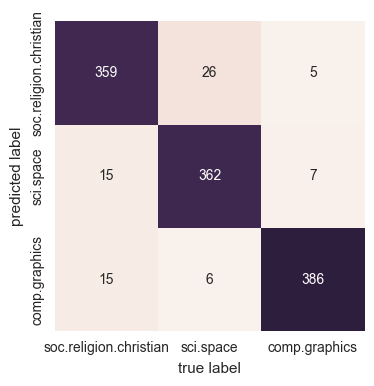

In [515]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

Small improvement. In this case, PCA reduced the dimensionality of the data without loosing too much informatin.
Finally, let's use it again on the Obama Clinton Sanders dataset.

In [532]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [533]:
TFVects_OCS = TFVectorizer.fit_transform(train.data)
TFVects_OCS_test = TFVectorizer.transform(test.data)

In [534]:
clf.fit(TFVects_OCS,train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [535]:
labels = clf.predict(TFVects_OCS_test)

Confusion matrix:

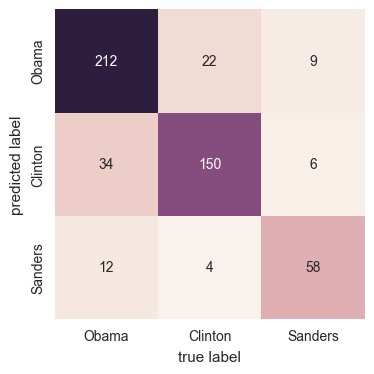

In [536]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [537]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.830867858758
0.828402366864
0.828826514099
